# Old town code

## Raw midi

### Import

In [701]:
import pandas
import sklearn
import numpy
from sklearn import model_selection
from sklearn import linear_model

### Load data

In [702]:
df = pandas.read_csv("samples.csv")
keys = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
df['Numeric Key'] = df['Key'].map(lambda k : keys.index(k))
df.sample(n=5)

,Key,W,X,Y,Z,Numeric Key
4454,D,13,67,31,109,3
3121,E,88,105,23,90,4
4776,D,73,47,93,117,3
849,G,55,93,50,57,6
4448,E,13,105,30,85,4


### Split into training and test sets

In [703]:
train, test = sklearn.model_selection.train_test_split(df, test_size=0.20, random_state=12)

print("Training set size: %i" % len(train))
print("Test set size: %i" % len(test))

test.sample(5)

Training set size: 4000
Test set size: 1000


,Key,W,X,Y,Z,Numeric Key
4153,B,102,121,114,16,1
355,G,54,114,43,96,6
534,B,58,116,47,28,1
2395,G,74,66,71,84,6
668,G,122,21,107,21,6


### Support Vector Machine - no encoding

In [704]:
X_train = train.filter(items=["W", "X", "Y", "Z"])
y_train = train.filter(items=["Numeric Key"])

from sklearn.svm import SVC
svm_clf = SVC(gamma = 'scale')
svm_clf.fit(X_train, y_train.values.ravel())

print("D, F#, G and A are from %s (actually from D or G)." % keys[svm_clf.predict([[14, 18, 19, 21]])[0]])
print("G, B, F and C are from %s (actually from C)." % keys[svm_clf.predict([[55, 71, 17, 24]])[0]])
print("F, G, A and Bb are from %s (actually F or Bb)." % keys[svm_clf.predict([[77, 79, 81, 82]])[0]])

D, F#, G and A are from C (actually from D or G).
G, B, F and C are from D (actually from C).
F, G, A and Bb are from B (actually F or Bb).


### One hot encoding

In [705]:
def one_hot_midi(n):
  dummy = numpy.zeros(128)
  if n <= 128:
    dummy[n-1] = 1
  return dummy

def one_hot_dataframe(f):
    w = f['W'].map(one_hot_midi)
    x = f['X'].map(one_hot_midi)
    y = f['Y'].map(one_hot_midi)
    z = f['Z'].map(one_hot_midi)

    return pandas.concat([pandas.DataFrame(w.to_list()),
                          pandas.DataFrame(x.to_list()),
                          pandas.DataFrame(y.to_list()),
                          pandas.DataFrame(z.to_list())], axis=1)

X_train = one_hot_dataframe(train)

X_train.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Support Vector Machine - one hot encoding

In [706]:
y_train = train.filter(items=["Numeric Key"])

from sklearn.svm import SVC
svm_clf = SVC(gamma = 'scale')
svm_clf.fit(X_train, y_train.values.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [707]:
def two_d_one_hot(w, x, y, z):
    sample = numpy.concatenate([one_hot(w), one_hot(x), one_hot(y), one_hot(z)])
    return numpy.stack([sample])

print("D, F#, G and A are from %s (actually from D or G)." % keys[svm_clf.predict(two_d_one_hot(14, 18, 19, 21))[0]])
print("G, B, F and C are from %s (actually from C)." % keys[svm_clf.predict(two_d_one_hot(55, 71, 17, 24))[0]])
print("F, G, A and Bb are from %s (actually F or Bb)." % keys[svm_clf.predict(two_d_one_hot(77, 79, 81, 82))[0]])

D, F#, G and A are from C (actually from D or G).
G, B, F and C are from C (actually from C).
F, G, A and Bb are from F (actually F or Bb).


### Neural network

In [708]:
from tensorflow import keras

entry = keras.models.Sequential([keras.layers.Dense(12, input_shape=(512,))])
exit = keras.models.Sequential([keras.layers.Dense(7, input_shape=(12,), activation="sigmoid")])
encoder = keras.models.Sequential([entry, exit])

encoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

Train on 4000 samples
Epoch 1/20
4000/4000 [==============================] - 0s 123us/sample - loss: 0.1323
Epoch 2/20
4000/4000 [==============================] - 0s 35us/sample - loss: 0.1208
Epoch 3/20
4000/4000 [==============================] - 0s 36us/sample - loss: 0.1193
Epoch 4/20
4000/4000 [==============================] - 0s 35us/sample - loss: 0.1170
Epoch 5/20
4000/4000 [==============================] - 0s 38us/sample - loss: 0.1138
Epoch 6/20
4000/4000 [==============================] - 0s 38us/sample - loss: 0.1099
Epoch 7/20
4000/4000 [==============================] - 0s 35us/sample - loss: 0.1055
Epoch 8/20
4000/4000 [==============================] - 0s 35us/sample - loss: 0.1012
Epoch 9/20
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0971
Epoch 10/20
4000/4000 [==============================] - 0s 35us/sample - loss: 0.0933
Epoch 11/20
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0897
Epoch 12/20
4000/4000 [======

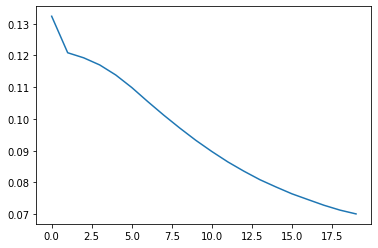

In [709]:
def one_hot_key(n):
  dummy = numpy.zeros(7)
  if n <= 7:
    dummy[n-1] = 1
  return dummy

hot_y_train = numpy.stack(y_train['Numeric Key'].map(one_hot_key).to_numpy())

history = encoder.fit(X_train.to_numpy(), hot_y_train, epochs=20)

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d

plt.plot(history.history['loss'], label='Training loss')
plt.show()

In [710]:
y_test = test.filter(items=["Numeric Key"])
hot_y_test = numpy.stack(y_test['Numeric Key'].map(one_hot_key).to_numpy())

X_test = one_hot_dataframe(test)

encoder.evaluate(X_test.to_numpy(), hot_y_test)

1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.08935022336244583

In [711]:
prediction = encoder.predict(two_d_one_hot(14, 18, 19, 21))
print("D, F#, G and A are from %s (actually from D or G)." % keys[numpy.argmax(prediction)])
prediction

D, F#, G and A are from C (actually from D or G).


array([[0.00109074, 0.19032206, 0.33909714, 0.08203333, 0.1245127 ,
        0.24927615, 0.06333758]], dtype=float32)

In [712]:
prediction = encoder.predict(two_d_one_hot(55, 71, 17, 24))
print("G, B, F and C are from %s (actually from C)." % keys[numpy.argmax(prediction)])
prediction

G, B, F and C are from B (actually from C).


array([[0.00771349, 0.5088662 , 0.10904049, 0.00929825, 0.2800678 ,
        0.15893763, 0.02936301]], dtype=float32)

In [713]:
prediction = encoder.predict(two_d_one_hot(73, 28, 81, 80))
print("C#, E, A and G# are from %s (actually A or E)." % keys[numpy.argmax(prediction)])
prediction

C#, E, A and G# are from G (actually A or E).


array([[0.1121053 , 0.02500179, 0.21167442, 0.10608918, 0.01444825,
        0.04226344, 0.32731023]], dtype=float32)

In [714]:
prediction = encoder.predict(two_d_one_hot(13, 122, 104, 33))
print("C#, D, E and A are from %s (actually A or D)." % keys[numpy.argmax(prediction)])
prediction

C#, D, E and A are from G (actually A or D).


array([[0.07384681, 0.0075894 , 0.08633572, 0.34132546, 0.00665493,
        0.04095157, 0.5298312 ]], dtype=float32)